In [170]:
import pandas as pd
import numpy as np
import re
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

In [171]:
df_full = pd.read_csv("processed-data/processed_2023_qc.csv")
df_full["date"] = pd.to_datetime(df_full["date"])

## Checking the quality of data

***QC test categories:***

G - Good


F - Too many minutely flags failed QC


M - Missing too many time-steps

In [172]:
df_qc = df_full.loc[:, ["date", "time"] + df_full.columns[df_full.columns.str.startswith("qcscore")].tolist()]
qc_list = [col for col in df_qc.columns if col not in ["date", "time"]]
(df_qc[qc_list].apply(pd.Series.value_counts).fillna(0)
                                             .astype(int)
                                             .sort_values(by="qcscore", ascending=False))

,qcscore,qcscore_maxt,qcscore_mint,qcscore_rh,qcscore_ws,qcscore_wd,qcscore_60rf,qcscore_sol
G,8755,8760,8760,8760,8760,5556,8759,8709
F,5,0,0,0,0,0,0,51
M,0,0,0,0,0,3025,1,0


In [173]:
df = df_full[["date", 
              "time", 
              "Air Temperature in degree C", 
              "Minimum Air Temperature in degree C", 
              "Maximum Air Temperature in degree C",
              "Relative Humidity in %",
              "Wind Speed in km/hr",
              "Wind Direction", 
              "Past 60-Minutes Rainfall in mm", 
              "Solar Radiation in W/m^2"]]

df = df.rename(columns={"Air Temperature in degree C": "temp(c)",
                        "Minimum Air Temperature in degree C": "min_temp(c)",
                        "Maximum Air Temperature in degree C": "max_temp(c)",
                        "Relative Humidity in %": "rel_humid(%)",
                        "Wind Speed in km/hr": "wind_speed(km/hr)",
                        "Wind Direction": "wind_dir",
                        "Past 60-Minutes Rainfall in mm": "rainfall(mm)",
                        "Solar Radiation in W/m^2": "sol_rad(W/m^2)"})

df["hour"] = np.arange(df.shape[0])

df.head(5)

,date,time,temp(c),min_temp(c),max_temp(c),rel_humid(%),wind_speed(km/hr),wind_dir,rainfall(mm),sol_rad(W/m^2),hour
0,2023-01-01,00:00:00,16.0,12.3,19.8,76.5,2.9,9.8,0.0,0.0,0
1,2023-01-01,01:00:00,16.0,16.0,16.1,76.8,3.1,12.2,0.0,0.0,1
2,2023-01-01,02:00:00,15.7,15.7,16.1,76.6,3.8,11.1,0.0,0.0,2
3,2023-01-01,03:00:00,15.2,15.2,16.1,78.5,3.3,8.5,0.0,0.0,3
4,2023-01-01,04:00:00,15.0,15.0,16.1,79.5,3.7,12.6,0.0,0.0,4


# Yearly Analysis

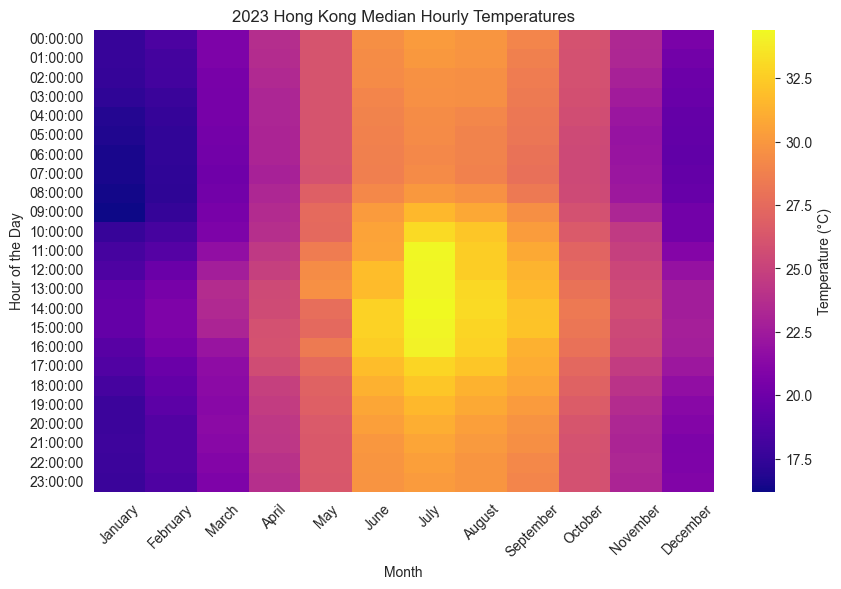

In [174]:
# Plot a heatmap of the median hourly temperature distribution across the whole year
df_temp = df[["date", "time", "temp(c)"]].copy()
df_temp["month"] = df["date"].dt.strftime("%B")
df_temp["month_num"] = df["date"].dt.month
df_temp = df_temp.drop(columns={"date"})
df_avg_hr_temp_year = (df_temp.groupby(["time", "month"])
                              .aggregate("median")
                              .sort_values(by=["month_num", "time"])
                              .reset_index())

month_order = ["January", "February", "March", "April", "May", "June", 
               "July", "August", "September", "October", "November", "December"]

df_avg_hr_temp_year["month"] = pd.Categorical(df_avg_hr_temp_year["month"], 
                                              categories=month_order, 
                                              ordered=True)

heatmap_data = df_avg_hr_temp_year.pivot(index="time", 
                                         columns="month", 
                                         values="temp(c)")

# Plot the heatmap
plt.figure(figsize=(10, 6))

sns.heatmap(heatmap_data, 
            annot=False, 
            cmap="plasma", 
            cbar_kws={"label": "Temperature (°C)"})

plt.xticks(rotation=45)
plt.title("2023 Hong Kong Median Hourly Temperatures")
plt.ylabel("Hour of the Day")
plt.xlabel("Month")
plt.savefig("output-graphs/hourly_year_temp.png")
plt.show()

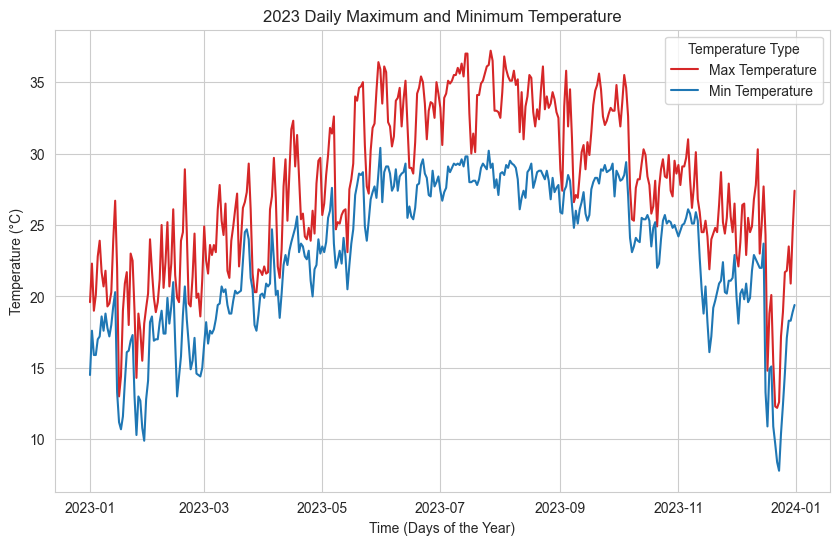

In [175]:
df_maxmin_temp = df[["date", "temp(c)"]].copy()
df_max_grouped = df_maxmin_temp.groupby(["date"]).max().rename(columns={"temp(c)": "max_temp(c)"})
df_min_grouped = df_maxmin_temp.groupby(["date"]).min().rename(columns={"temp(c)": "min_temp(c)"})
df_maxmin = df_max_grouped.merge(df_min_grouped, left_index=True, right_index=True).reset_index()


df_melted = df_maxmin.melt(id_vars=["date"], value_vars=["max_temp(c)", "min_temp(c)"], 
                           var_name="Temperature Type", value_name="Temperature")

# Plot config
custom_palette = {"max_temp(c)": "#D62728", "min_temp(c)": "#1F77B4"}
legend_labels = {"max_temp(c)": "Max Temperature", "min_temp(c)": "Min Temperature"}

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(x="date", 
             y="Temperature", 
             hue="Temperature Type", 
             data=df_melted,
             palette=custom_palette) 

sns.set_style("whitegrid")

# Set custom legend
legend = plt.legend(title="Temperature Type")
for text in legend.get_texts():
    text.set_text(legend_labels[text.get_text()])
    
plt.title("2023 Daily Maximum and Minimum Temperature")
plt.ylabel("Temperature (°C)")
plt.xlabel("Time (Days of the Year)")
# plt.xticks(rotation=30)
plt.savefig("output-graphs/daily_year_maxmin_temp.png")

plt.show()

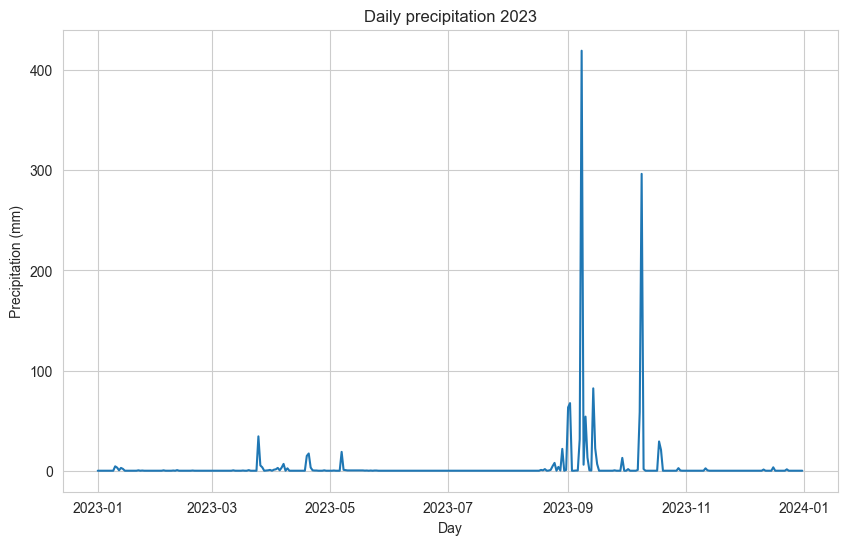

In [187]:
df_precip = df[["date", "rainfall(mm)"]]
df_precip_daily = df[["date", "rainfall(mm)"]].groupby("date")["rainfall(mm)"].sum().reset_index()

# Create the plot
plt.figure(figsize=(10, 6))

sns.lineplot(x="date", y="rainfall(mm)", data=df_precip_daily)
plt.title("Daily precipitation 2023")
plt.ylabel("Precipitation (mm)")
plt.xlabel("Day")
# plt.xticks(list(df_jan_week["hour"][::24]) + [df_jan_week["hour"].iloc[-1]])
plt.show()

# Seasonal Analysis

In [178]:
df_summer = df[(df["date"] >= "2023-06-01") & (df["date"] < "2023-09-01")].copy()
df_winter = df[ (df["date"] < "2023-03-01") |
               (df["date"] >= "2023-12-01")].copy()

## Interpolating wind speed 35 storeys high (35th floor)

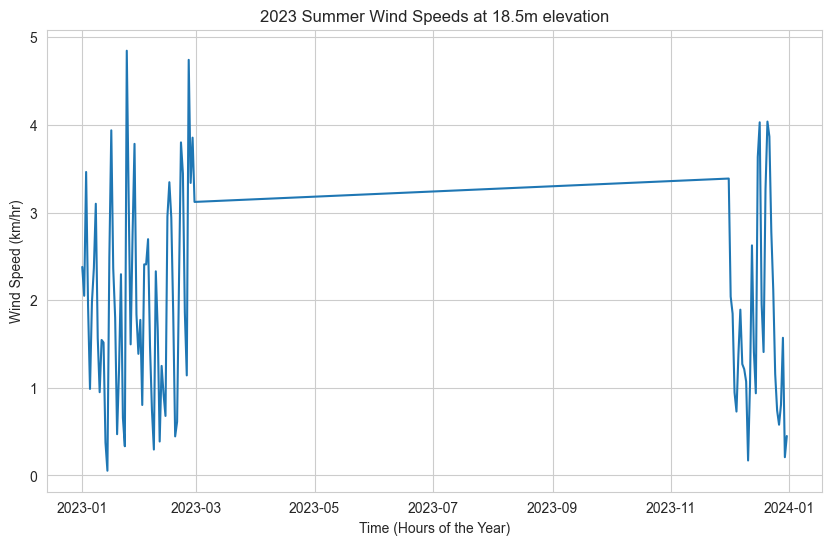

In [179]:
plt.figure(figsize=(10, 6))

df_summer_day = df_summer.groupby("date")[["wind_speed(km/hr)", 
                                           "temp(c)",
                                           "rel_humid(%)"]].mean().reset_index()

df_winter_day = df_winter.groupby("date")["wind_speed(km/hr)"].mean().reset_index()

sns.lineplot(x="date", y="wind_speed(km/hr)", data=df_winter_day)
plt.title("2023 Summer Wind Speeds at 18.5m elevation")
plt.ylabel("Wind Speed (km/hr)")
plt.xlabel("Time (Hours of the Year)")
# plt.xticks(list(df_summer["hour"][::24]) + [df_summer["hour"].iloc[-1]])
plt.show()

In [180]:
print(df_summer_day["wind_speed(km/hr)"].mean())
print(df_summer_day["temp(c)"].mean())

0.761911231884058
30.610688405797102


In [181]:
df_test = df[["date", "wind_speed(km/hr)"]].groupby("date").mean()
df_test.mean()

wind_speed(km/hr)    1.498094
dtype: float64

In [182]:
df_summer[["wind_speed(km/hr)"]]

,wind_speed(km/hr)
3624,0.1
3625,0.1
3626,0.1
3627,0.1
3628,0.0
...,...
5827,0.9
5828,1.6
5829,2.1
5830,0.2


In [183]:
# Use power law
df_summer["wind_speed_adj(km/hr)"] = df_summer[["wind_speed(km/hr)"] * ]

SyntaxError: invalid syntax (2704747507.py, line 2)

In [ ]:
df_summer_sol = (df_summer[["time", "sol_rad(W/m^2)"]].groupby(by="time")
                                                      .mean()
                                                      .rename(columns={"sol_rad(W/m^2)": "summer_sol"})
                                                      .reset_index())
df_winter_sol = (df_winter[["time", "sol_rad(W/m^2)"]].groupby(by="time")
                                                      .mean()
                                                      .rename(columns={"sol_rad(W/m^2)": "winter_sol"})
                                                      .reset_index())

df_sol = df_summer_sol.merge(df_winter_sol, on="time", how="outer", indicator=True).reset_index()  

# Plot
plt.figure(figsize=(8, 5))
plt.plot(df_sol["time"], df_sol["summer_sol"], 'r', label="Typical Summer Day")
plt.plot(df_sol["time"], df_sol["winter_sol"], 'b', label="Typical Winter Day")
plt.fill_between(df_sol["time"], df_sol["summer_sol"], color='red', alpha=0.2)
plt.fill_between(df_sol["time"], df_sol["winter_sol"], color='blue', alpha=0.2)

# Annotate Midday
plt.plot([12, 12], [0, 700], color='k', linestyle="--", alpha=0.5)
plt.text(11.3, 710, "Midday", rotation=0, verticalalignment='bottom', fontsize=10)

# Labels and legend
plt.xlabel("Time of the Day (Hour)")
plt.ylabel("Solar Irradiance (W/m²)")
plt.title("Solar Irradiance Over a Day")
plt.xticks(range(0, 24, 2), rotation=30)
plt.yticks(range(0, 1000, 200))
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)

# Show plot
plt.show()

# Weekly Analysis

Extracting data from the week of the 2nd Monday of January and July to represent Winter and Summer weather in Hong Kong.

In [ ]:
df_jan_week = df[(df["date"] >= "2023-01-09") & (df["date"] < "2023-01-16")].copy()
df_july_week = df[(df["date"] >= "2023-07-10") & (df["date"] < "2023-07-17")].copy()

In [ ]:
df_july_week

In [ ]:
plt.figure(figsize=(10, 6))

sns.lineplot(x="hour", y="temp(c)", data=df_jan_week)
plt.title("09/01 - 16/01 Hourly Air Temperature")
plt.ylabel("Temperature (°C)")
plt.xlabel("Time (Hours of the Year)")
plt.xticks(list(df_jan_week["hour"][::24]) + [df_jan_week["hour"].iloc[-1]])
plt.show()

In [ ]:
cols_plot = {"temp(c)": "Air Temperature (°C)", 
             "rel_humid(%)": "Relative Humidity (%)", 
             "sol_rad(W/m^2)": "Solar Radiation (W/m^2)",
             "rainfall(mm)": "Precipitation (mm)"}

fig, axes = plt.subplots(len(cols_plot), 1, figsize=(10, 8), sharex=True)

# Loop through each column and plot on a separate subplot
for i, (key, value) in enumerate(cols_plot.items()):
    cleaned_label = re.sub(r"\s*\(.*?\)", "", value)
    sns.lineplot(x="hour", y=key, data=df_jan_week, ax=axes[i])
    axes[i].set_title(f"09/01 - 16/01 Hourly {cleaned_label}")
    axes[i].set_ylabel(value)

# Set common x-axis label
axes[-1].set_xlabel("Hours")

plt.xticks(list(df_jan_week["hour"][::24]) + [df_jan_week["hour"].iloc[-1]])
plt.tight_layout()  # Adjust layout
plt.show()                                 

In [ ]:
plt.figure(figsize=(10, 6))

sns.lineplot(x="hour", y="temp(c)", data=df_july_week)
plt.title("10/07 - 16/07 Hourly Air Temperature")
plt.ylabel("Temperature (°C)")
plt.xlabel("Time (Hours of the Year)")
plt.xticks(list(df_july_week["hour"][::24]) + [df_july_week["hour"].iloc[-1]])
plt.show()

In [ ]:
cols_plot = {"temp(c)": "Air Temperature (°C)", 
             "rel_humid(%)": "Relative Humidity (%)", 
             "sol_rad(W/m^2)": "Solar Radiation (W/m^2)",
             "rainfall(mm)": "Precipitation (mm)"}

fig, axes = plt.subplots(len(cols_plot), 1, figsize=(10, 8), sharex=True)

# Loop through each column and plot on a separate subplot
for i, (key, value) in enumerate(cols_plot.items()):
    cleaned_label = re.sub(r"\s*\(.*?\)", "", value)
    sns.lineplot(x="hour", y=key, data=df_july_week, ax=axes[i])
    axes[i].set_title(f"10/07 - 17/07 Hourly {cleaned_label}")
    axes[i].set_ylabel(value)

# Set common x-axis label
axes[-1].set_xlabel("Hours")

plt.xticks(list(df_july_week["hour"][::24]) + [df_july_week["hour"].iloc[-1]])
plt.tight_layout()  # Adjust layout
plt.show()

# Solar Radiation and Temperature Correlation Investigation

In [ ]:
df_soltemp = df[["date", "time", "temp(c)", "sol_rad(W/m^2)"]]

plt.figure(figsize=(10, 6))

sns.scatterplot(x="temp(c)", y="sol_rad(W/m^2)", data=df_soltemp)

# call the scipy function for pearson correlation
r, p = sp.stats.pearsonr(x=df_soltemp["temp(c)"], y=df_soltemp["sol_rad(W/m^2)"])
# annotate the pearson correlation coefficient text to 2 decimal places
ax = plt.gca() 
plt.text(.05, .8, 'r={:.2f}'.format(r), transform=ax.transAxes)

plt.title("2023 Direct Solar Radiation vs Air Temperature")
plt.ylabel("Solar Radiation (W/m^2)")
plt.xlabel("Air Temperature (°C)")
plt.show()

In [ ]:
df_soltemp = df[df["sol_rad(W/m^2)"] > 10]

plt.figure(figsize=(10, 6))

sns.scatterplot(x="temp(c)", y="sol_rad(W/m^2)", data=df_soltemp)

# call the scipy function for pearson correlation
r, p = sp.stats.pearsonr(x=df_soltemp["temp(c)"], y=df_soltemp["sol_rad(W/m^2)"])
# annotate the pearson correlation coefficient text to 2 decimal places
ax = plt.gca() 
plt.text(.05, .8, 'r={:.2f}'.format(r), transform=ax.transAxes)

plt.title("2023 Direct Solar Radiation vs Air Temperature")
plt.ylabel("Solar Radiation (W/m^2)")
plt.xlabel("Air Temperature (°C)")
plt.show()

In [ ]:
df_soltemp_winter = df_soltemp[(df_soltemp["date"] >= "2023-12-01") | (df_soltemp["date"] < "2023-03-01")].copy()
df_soltemp_summer = df_soltemp[(df_soltemp["date"] >= "2023-06-01") & (df_soltemp["date"] < "2023-09-01")].copy()

In [ ]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x="temp(c)", y="sol_rad(W/m^2)", data=df_soltemp_summer)

# call the scipy function for pearson correlation
r, p = sp.stats.pearsonr(x=df_soltemp_summer["temp(c)"], y=df_soltemp_summer["sol_rad(W/m^2)"])
# annotate the pearson correlation coefficient text to 2 decimal places
ax = plt.gca() 
plt.text(.05, .8, 'r={:.2f}'.format(r), transform=ax.transAxes)

plt.title("2023 Direct Solar Radiation vs Air Temperature Summer")
plt.ylabel("Solar Radiation (W/m^2)")
plt.xlabel("Air Temperature (°C)")
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x="temp(c)", y="sol_rad(W/m^2)", data=df_soltemp_winter)

# call the scipy function for pearson correlation
r, p = sp.stats.pearsonr(x=df_soltemp_winter["temp(c)"], y=df_soltemp_winter["sol_rad(W/m^2)"])
# annotate the pearson correlation coefficient text to 2 decimal places
ax = plt.gca() 
plt.text(.05, .8, 'r={:.2f}'.format(r), transform=ax.transAxes)

plt.title("2023 Direct Solar Radiation vs Air Temperature Winter")
plt.ylabel("Solar Radiation (W/m^2)")
plt.xlabel("Air Temperature (°C)")
plt.show()

In [ ]:
df_solsummer = df_soltemp_summer[["time", "sol_rad(W/m^2)"]]
df_solsummer = df_solsummer.groupby(by="time").median("sol_rad(W/m^2)")

plt.figure(figsize=(10, 6))

sns.lineplot(x="time", y="sol_rad(W/m^2)", data=df_solsummer)
plt.title("10/07 - 16/07 Hourly Air Temperature")
plt.ylabel("Temperature (°C)")
plt.xlabel("Time (Hours of the Year)")
plt.show()